In [2]:
import os
import toml
import pandas as pd
from utils.config_helper import update_nested_toml, load_config

breast
lung
prostate
stomach
rectal

In [3]:
TYPE = input("Enter the type of the config file: ")
CONFIG_PATH = f"../config/{TYPE}.toml"
config = load_config(CONFIG_PATH)

In [4]:
def inspect_nan(df, name):
    print(df[pd.isna(df[name])])

In [5]:
beta_file_number = config["init"]["hyper"]["beta_file_number"]
test_ratio = config["init"]["hyper"]["test_ratio"]
seed = config["init"]["hyper"]["splitting_seed"]
normal_number_0 = config["init"]["hyper"]["normal_number_0"]
if beta_file_number == 2:
    normal_number_1 = config["init"]["hyper"]["normal_number_1"]
data_source = config["init"]["hyper"]["data_source"]
is_columns_duplicated = config["init"]["hyper"]["is_columns_duplicated"]
if data_source == "GDC_stomach_GSE99553":  # god forgive me
    is_columns_duplicated_1 = config["init"]["hyper"]["is_columns_duplicated_1"]

In [6]:
trainOutPath = f"../{TYPE}/result/{data_source}/train{int(100-test_ratio*100)}"
testOutPath = f"../{TYPE}/result/{data_source}/test{int(test_ratio*100)}"

### Section. 0 Merge and Split Champ Data 
(if there are more than one normalized beta data)

#### Summary
- beta data is split into train and test
- all beta data will the following format
  - column 0 is the id of the sample
  - column 1 to n is the beta value of each CpG site
  - normal samples come first, then tumor samples

In [8]:
df0 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_0.csv")

In [9]:
if beta_file_number == 2:
    df1 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_1.csv")

In [10]:
# DEBUG
df0
# END

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104
0,cg00000957,0.840645,0.840645,0.838333,0.838333,0.841180,0.841180,0.854801,0.854801,0.826240,...,0.858369,0.858369,0.847875,0.847875,0.881325,0.881325,0.845785,0.845785,0.879158,0.879158
1,cg00001349,0.868204,0.868204,0.875523,0.875523,0.708645,0.708645,0.763812,0.763812,0.618374,...,0.879759,0.879759,0.759153,0.759153,0.835826,0.835826,0.842740,0.842740,0.862857,0.862857
2,cg00001583,0.106897,0.106897,0.520205,0.520205,0.113957,0.113957,0.213113,0.213113,0.063247,...,0.790970,0.790970,0.100963,0.100963,0.247293,0.247293,0.642551,0.642551,0.709084,0.709084
3,cg00002028,0.026257,0.026257,0.034299,0.034299,0.030409,0.030409,0.016650,0.016650,0.026056,...,0.021136,0.021136,0.032977,0.032977,0.025518,0.025518,0.045711,0.045711,0.035661,0.035661
4,cg00002719,0.029272,0.029272,0.490811,0.490811,0.052727,0.052727,0.045307,0.045307,0.035076,...,0.713871,0.713871,0.542124,0.542124,0.137699,0.137699,0.621165,0.621165,0.483589,0.483589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373335,cg27656573,0.972378,0.972378,0.952102,0.952102,0.956166,0.956166,0.971104,0.971104,0.961684,...,0.948461,0.948461,0.943028,0.943028,0.969645,0.969645,0.950949,0.950949,0.963958,0.963958
373336,cg27657363,0.969164,0.969164,0.931059,0.931059,0.949989,0.949989,0.952977,0.952977,0.942600,...,0.936938,0.936938,0.931106,0.931106,0.935278,0.935278,0.939360,0.939360,0.953841,0.953841
373337,cg27657537,0.131392,0.131392,0.282966,0.282966,0.080608,0.080608,0.259545,0.259545,0.103994,...,0.445348,0.445348,0.592364,0.592364,0.293623,0.293623,0.538090,0.538090,0.671126,0.671126
373338,cg27662611,0.033896,0.033896,0.033763,0.033763,0.050093,0.050093,0.041935,0.041935,0.040316,...,0.029657,0.029657,0.031203,0.031203,0.031619,0.031619,0.035420,0.035420,0.055974,0.055974


In [11]:
# DEBUG
df1
# END

NameError: name 'df1' is not defined

In [12]:
# potential feature loss
if beta_file_number == 2:
    feature_name_0 = df0.iloc[:, 0].tolist()
    feature_name_1 = df1.iloc[:, 0].tolist()

    feature_name = list(set(feature_name_0).intersection(feature_name_1))
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name_0)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_1", len(feature_name_1)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_intersection", len(feature_name)
    )
elif beta_file_number == 1:
    feature_name = df0.iloc[:, 0].tolist()
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name)
    )

In [13]:
if beta_file_number == 2:
    df0_join = df0[df0.iloc[:, 0].isin(feature_name)]
    df1_join = df1[df1.iloc[:, 0].isin(feature_name)]

In [14]:
if beta_file_number == 2:
    df0_join = df0_join.iloc[:, 1::is_columns_duplicated]
    if data_source == "GDC_stomach_GSE99553":  # god forgive me
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated_1]
    else:
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated]
    df0_join.reset_index(drop=True, inplace=True)
    df1_join.reset_index(drop=True, inplace=True)
    df0_join_normal = df0_join.iloc[:, :normal_number_0]
    df0_join_tumor = df0_join.iloc[:, normal_number_0:]
    df1_join_normal = df1_join.iloc[:, :normal_number_1]
    df1_join_tumor = df1_join.iloc[:, normal_number_1:]
elif beta_file_number == 1:
    df0_join = df0.iloc[:, 1::is_columns_duplicated]

In [15]:
if beta_file_number == 2:
    df_normal = pd.concat([df0_join_normal, df1_join_normal], axis=1)
    df_tumor = pd.concat([df0_join_tumor, df1_join_tumor], axis=1)

In [16]:
# drop those samples with missing value
# note: could use padding or other methods to fill the missing value

if beta_file_number == 2:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfc_shape", df_tumor.shape
    )
    df_normal.dropna(inplace=True, axis=1)
    df_tumor.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfc_shape", df_tumor.shape
    )
elif beta_file_number == 1:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_df_shape", df0_join.shape
    )
    df0_join.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_df_shape", df0_join.shape
    )

In [17]:
# Combine the normal and tumor data
if beta_file_number == 2:
    X = pd.concat([df_normal, df_tumor], axis=1).T
    y = [0] * df_normal.shape[1] + [1] * df_tumor.shape[1]
elif beta_file_number == 1:
    X = df0_join.T
    y = [0] * normal_number_0 + [1] * (df0_join.shape[1] - normal_number_0)


In [19]:
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=seed
)

In [21]:
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_X_train_shape", X_train.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_y_train_shape", len(y_train)
)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_X_train_shape", X_resampled.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_y_train_shape", len(y_resampled)
)


D:\Users\005535\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Users\005535\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [22]:
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,373330,373331,373332,373333,373334,373335,373336,373337,373338,373339
0,0.874194,0.898549,0.398857,0.020607,0.050160,0.760982,0.011427,0.215980,0.946351,0.010709,...,0.859529,0.065364,0.068077,0.948688,0.394797,0.964447,0.956472,0.398151,0.054754,0.807358
1,0.854382,0.784828,0.218870,0.035629,0.248093,0.506881,0.029541,0.254958,0.952804,0.026908,...,0.537996,0.042060,0.060707,0.940770,0.402364,0.918125,0.900551,0.279611,0.050552,0.844948
2,0.847503,0.843355,0.352496,0.013120,0.164024,0.491313,0.004611,0.207065,0.964780,0.031033,...,0.617928,0.012982,0.047191,0.964919,0.723513,0.947560,0.947550,0.230759,0.031211,0.851652
3,0.868061,0.842552,0.233753,0.016112,0.035108,0.639848,0.013337,0.310042,0.969242,0.021605,...,0.873315,0.074766,0.029090,0.970258,0.536661,0.962072,0.955651,0.374348,0.037064,0.914446
4,0.796901,0.800717,0.172407,0.039093,0.127151,0.576311,0.017989,0.202631,0.928545,0.025082,...,0.432770,0.038629,0.082540,0.934918,0.390929,0.933991,0.936911,0.207405,0.036866,0.826680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,0.840390,0.720603,0.076444,0.011180,0.043671,0.580141,0.017776,0.263465,0.951016,0.033463,...,0.455161,0.019977,0.041181,0.967453,0.541578,0.956751,0.960248,0.124819,0.034598,0.848497
798,0.869196,0.820729,0.236100,0.011574,0.053275,0.673788,0.011725,0.343092,0.959367,0.018597,...,0.776069,0.048339,0.046512,0.966285,0.465367,0.963411,0.959866,0.311721,0.030701,0.899471
799,0.839838,0.789607,0.116098,0.022432,0.043107,0.561677,0.011432,0.310945,0.961374,0.022983,...,0.574184,0.025060,0.055560,0.965306,0.599410,0.970749,0.956876,0.159116,0.062245,0.854138
800,0.831794,0.725962,0.099156,0.034603,0.040768,0.441947,0.012494,0.247307,0.960900,0.029152,...,0.487354,0.022187,0.044053,0.960560,0.846388,0.961602,0.945373,0.088927,0.025888,0.869941


In [23]:
train_class_distribution = Counter(y_resampled)
testing_class_distribution = Counter(y_test)

update_nested_toml("preprocess.merge_and_split", "training_set_samples", len(X_resampled))
update_nested_toml("preprocess.merge_and_split", "testing_set_samples", len(X_test))
update_nested_toml(
    "preprocess.merge_and_split",
    "training_class_distribution",
    [train_class_distribution[0], train_class_distribution[1]],
)
update_nested_toml(
    "preprocess.merge_and_split",
    "testing_class_distribution",
    [testing_class_distribution[0], testing_class_distribution[1]],
)

In [24]:
X_resampled.columns = feature_name
X_resampled["label"] = y_resampled
X_resampled.sort_values(by=["label"], inplace=True)
train_df = X_resampled.T
train_df.columns = range(train_df.shape[1])

X_test.columns = feature_name
X_test["label"] = y_test
X_test.sort_values(by=["label"], inplace=True)
test_df = X_test.T
test_df.columns = range(test_df.shape[1])

train_df.insert(0, "Unnamed: 0", train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.insert(0, "Unnamed: 0", test_df.index)
test_df.reset_index(drop=True, inplace=True)

D:\Users\005535\AppData\Local\Temp\ipykernel_17796\1430446889.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_resampled["label"] = y_resampled


In [25]:
# DEBUG
train_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,792,793,794,795,796,797,798,799,800,801
0,cg00000957,0.839838,0.869196,0.840390,0.867300,0.841462,0.870928,0.831764,0.856623,0.848833,...,0.871531,0.894763,0.851060,0.843531,0.903909,0.867909,0.846249,0.906945,0.831055,0.874194
1,cg00001349,0.789607,0.820729,0.720603,0.706520,0.759784,0.796039,0.734736,0.855053,0.733856,...,0.852018,0.790230,0.639505,0.642323,0.792060,0.843404,0.712787,0.919743,0.823128,0.898549
2,cg00001583,0.116098,0.236100,0.076444,0.099039,0.092811,0.241996,0.097386,0.370248,0.097112,...,0.285456,0.590495,0.372846,0.285800,0.540008,0.333855,0.390848,0.625366,0.119337,0.398857
3,cg00002028,0.022432,0.011574,0.011180,0.022356,0.022604,0.010737,0.037448,0.014392,0.033028,...,0.046700,0.028303,0.044283,0.044121,0.018964,0.061649,0.031211,0.027937,0.028180,0.020607
4,cg00002719,0.043107,0.053275,0.043671,0.037571,0.037241,0.062696,0.039086,0.413051,0.038128,...,0.624151,0.667853,0.174575,0.211430,0.699954,0.259972,0.272155,0.366524,0.504806,0.050160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373336,cg27657363,0.956876,0.959866,0.960248,0.944398,0.960477,0.963603,0.945100,0.963328,0.954410,...,0.896874,0.933151,0.949773,0.925802,0.962224,0.954252,0.886726,0.952598,0.948711,0.956472
373337,cg27657537,0.159116,0.311721,0.124819,0.209004,0.210694,0.260614,0.091882,0.524706,0.122102,...,0.576389,0.507485,0.407807,0.339295,0.685281,0.473129,0.381828,0.624767,0.396211,0.398151
373338,cg27662611,0.062245,0.030701,0.034598,0.051944,0.071717,0.027277,0.027135,0.040091,0.031608,...,0.067101,0.354402,0.032201,0.023581,0.050569,0.085238,0.027678,0.026869,0.048471,0.054754
373339,cg27665648,0.854138,0.899471,0.848497,0.883312,0.887948,0.886936,0.868528,0.901669,0.865901,...,0.831698,0.912109,0.896388,0.869179,0.895742,0.911328,0.782291,0.907069,0.888137,0.807358


In [26]:
# DEBUG
test_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,cg00000957,0.845864,0.835681,0.853063,0.841180,0.840645,0.833973,0.854618,0.820812,0.862565,...,0.838264,0.844825,0.892887,0.867261,0.852356,0.823961,0.890865,0.830125,0.870176,0.857789
1,cg00001349,0.773967,0.898174,0.720905,0.708645,0.868204,0.782644,0.775534,0.824775,0.797306,...,0.797339,0.811410,0.836854,0.855619,0.853462,0.892725,0.854986,0.823448,0.897210,0.876160
2,cg00001583,0.144976,0.036853,0.279087,0.113957,0.106897,0.134871,0.329480,0.316795,0.046604,...,0.163597,0.292316,0.196342,0.640031,0.357947,0.534485,0.588813,0.147546,0.728655,0.276138
3,cg00002028,0.027506,0.032216,0.035949,0.030409,0.026257,0.033763,0.023366,0.026860,0.027793,...,0.061315,0.051471,0.038849,0.029779,0.038226,0.020759,0.035198,0.025986,0.030020,0.029392
4,cg00002719,0.058274,0.035748,0.045736,0.052727,0.029272,0.035318,0.047342,0.044884,0.042019,...,0.095846,0.657692,0.322644,0.612964,0.447518,0.849988,0.647744,0.147761,0.763429,0.128699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373336,cg27657363,0.948103,0.949634,0.948849,0.949989,0.969164,0.926727,0.944173,0.963408,0.951192,...,0.935086,0.923680,0.953148,0.949006,0.935257,0.945365,0.961405,0.979970,0.968018,0.954377
373337,cg27657537,0.204987,0.114482,0.277116,0.080608,0.131392,0.164756,0.144737,0.315726,0.101441,...,0.365117,0.469148,0.339899,0.490546,0.407895,0.604613,0.682518,0.154611,0.697369,0.213356
373338,cg27662611,0.047586,0.076038,0.042346,0.050093,0.033896,0.034158,0.032237,0.089901,0.065757,...,0.032431,0.061379,0.072765,0.056173,0.044317,0.018788,0.010555,0.027826,0.038915,0.039274
373339,cg27665648,0.908067,0.871213,0.879406,0.869885,0.875534,0.889955,0.901831,0.910694,0.931462,...,0.905337,0.870209,0.890811,0.935343,0.873291,0.923326,0.884342,0.888100,0.896972,0.926780


In [27]:
os.makedirs(f"{trainOutPath}", exist_ok=True)
os.makedirs(
    f"{testOutPath}",
    exist_ok=True,
)

train_df.to_csv(f"{trainOutPath}/all_beta_normalized_0.csv", index=False)
test_df.to_csv(f"{testOutPath}/all_beta_normalized_1.csv", index=False)

In [28]:
del train_df, test_df

In [29]:
zip_filename = f"{TYPE}_beta_files.zip"

In [30]:
import zipfile

with zipfile.ZipFile(zip_filename, "w") as zipf:
    zipf.write(
        f"{trainOutPath}/all_beta_normalized_0.csv", arcname="all_beta_normalized_0.csv"
    )
    zipf.write(
        f"{testOutPath}/all_beta_normalized_1.csv", arcname="all_beta_normalized_1.csv"
    )

In [39]:
from api import utils
service = utils.authenticate_drive()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=260407430533-mtnvh98d2pv3eo7mgb14h6en5827k7b5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A49401%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=i2ufZMAiwW5jsqn3yvm9vSqwn3tdUd&access_type=offline


INFO:google_auth_oauthlib.flow:"GET /?state=i2ufZMAiwW5jsqn3yvm9vSqwn3tdUd&code=4/0AanRRru4fNDSmbyNTXLZoV_EwDyUE7qDNTEiUt4ggsSxn8X_0ppvRkrxd9scFbUWqFRjBQ&scope=https://www.googleapis.com/auth/drive.file HTTP/1.1" 200 65
INFO:api.utils:New credentials obtained.
INFO:api.utils:Credentials saved to token.pickle.
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [40]:
directory = utils.create_folder(service, TYPE)

Created folder 'prostate' with ID: 1ooD-jZy16tqW6uxolGhjlbMDwAAFHJgi


In [41]:
utils.run_upload_with_separate_thread(service, directory, zip_filename)

INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 0% complete for prostate_beta_files.zip
INFO:api.utils:Upload 1% complete for prostate_beta_files.zip
INFO:api.utils:Upload 1% complete for prostate_beta_files.zip
INFO:api.utils:Upload 1% complete for prostate_beta_files.zip
INFO:api.utils:Upload 1% complete for prostate_beta_files.zip
INFO:api

### Sec. 1 dbeta calculation
#### Summary
- calculate the difference of beta value between tumor and normal samples
- the output file will have the following format
  - column 0 is the id of the sample
  - column 1 is the gene name
  - column 2 is the difference of beta value between tumor and normal samples

### Implementation
1. split normal and tumor samples
2. remove outliers in normal and tumor samples
3. calculate the mean of normal sammples
4. tumor - avg(normal)
5. calculate the mean of tumor samples
6. merge with DMP file
7. exclude the genes not in single comorbidity list

In [43]:
import gdown

##### Lung
https://drive.google.com/file/d/1cuKmDUgch4A0ULnj6XfTHuk6u0Xtz_3H/view?usp=sharing
##### Rectal
https://drive.google.com/file/d/11DZAwbtqVriSN8EhUNhQEEwVyntiycRa/view?usp=sharing
##### Stomach
https://drive.google.com/file/d/1QBklKEO61ZYqxo-gfjBsWg3mcREsTRc7/view?usp=sharing
##### Prostate
https://drive.google.com/file/d/1je1B4yopw7zJiSiXlzJmBx2xlcFtU1tk/view?usp=sharing
##### Breast
tbd

In [44]:
url = input()

output = 'download.zip'

In [45]:
gdown.download(url, output, quiet=False)

D:\Users\005535\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gdown\parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1je1B4yopw7zJiSiXlzJmBx2xlcFtU1tk
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1je1B4yopw7zJiSiXlzJmBx2xlcFtU1tk/view?usp=sharing
To: d:\pizza6inch\main_project\notebooks\download.zip
92.3kB [00:00, 3.83MB/s]


'download.zip'

In [46]:
import zipfile
import shutil

with zipfile.ZipFile("download.zip", "r") as zip_ref:
    zip_ref.extractall("download")

shutil.move("download/all_beta_normalized_0.csv", f"all_beta_normalized_0.csv")
shutil.move("download/all_beta_normalized_1.csv", f"all_beta_normalized_1.csv")

os.remove("download.zip")
shutil.rmtree("download")

BadZipFile: File is not a zip file

In [47]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [48]:
# remove outlier in terms of every column
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR * 1.5
    lower_fence = Q1 - IQR * 1.5
    return upper_fence, lower_fence


def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf = df[(df > lower_fence) & (df < upper_fence)]
    return ddf

In [49]:
config = load_config(CONFIG_PATH)
normal_count = config["preprocess"]["merge_and_split"]["training_class_distribution"][0]
all_beta_normalized_normal = train_df.iloc[:-1, 1 : normal_count + 1 :].T


all_beta_normalized_tumor = train_df.iloc[:-1, normal_count + 1 : :].T

In [50]:
all_beta_normalized_normal = no_outlier(all_beta_normalized_normal)
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [51]:
train_normal_avg = all_beta_normalized_normal.mean(skipna=True, axis=0)

In [52]:
train_normal_avg

0         0.854507
1         0.791627
2         0.178304
3         0.025882
4         0.049921
            ...   
373335    0.964996
373336    0.955585
373337    0.223514
373338    0.041729
373339    0.887818
Length: 373340, dtype: float64

In [53]:
all_beta_normalized_tumor

,0,1,2,3,4,5,6,7,8,9,...,373330,373331,373332,373333,373334,373335,373336,373337,373338,373339
401,0.888325,0.832968,0.695411,0.048017,0.727225,0.312515,0.018260,0.518893,0.940338,0.029709,...,0.859779,NaN,0.047253,0.938123,0.171332,0.955816,0.927675,0.578457,0.040895,0.908358
402,0.879158,0.862857,0.709084,0.035661,0.483589,0.402005,0.015316,0.267226,0.970474,0.024629,...,0.837683,0.022618,0.063714,0.969582,0.428615,0.963958,0.953841,0.671126,0.055974,0.924396
403,0.888019,0.869937,0.597571,0.036429,0.576867,0.575563,0.005518,0.558326,0.972794,0.020674,...,0.807002,0.033350,NaN,0.970555,0.393869,0.971233,0.963400,0.507865,0.047907,0.882344
404,0.842255,0.721084,0.307624,0.019180,0.297014,0.393510,0.011936,0.180016,0.942302,0.013034,...,0.639844,0.022981,0.039782,0.960157,0.628780,0.957418,0.910309,0.346398,0.035977,0.850335
405,0.891527,0.862903,0.530659,0.044347,0.418598,0.461024,0.009242,0.475367,0.957992,0.024730,...,0.807450,0.029601,0.049552,0.984605,0.671491,0.964492,0.949156,0.489872,0.029529,0.890880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,0.867909,0.843404,0.333855,0.061649,0.259972,0.642128,0.021148,0.387123,0.963479,0.033045,...,0.649792,0.038908,0.092662,0.958811,0.616285,0.942673,0.954252,0.473129,NaN,0.911328
798,0.846249,0.712787,0.390848,0.031211,0.272155,0.229669,0.012468,0.233090,0.960263,0.025211,...,0.797244,0.026163,0.073446,0.949240,0.667904,0.938267,0.886726,0.381828,0.027678,NaN
799,0.906945,0.919743,0.625366,0.027937,0.366524,0.798170,0.013077,0.138306,0.972448,0.021659,...,0.777234,0.035095,0.043318,0.948648,0.238429,0.960682,0.952598,0.624767,0.026869,0.907069
800,0.831055,0.823128,0.119337,0.028180,0.504806,0.592392,0.014958,0.226216,0.964566,0.025649,...,0.756582,0.023916,0.045202,0.973502,0.317561,0.928408,0.948711,0.396211,0.048471,0.888137


In [54]:
all_beta_normalized_tumor = all_beta_normalized_tumor.subtract(
    train_normal_avg, axis=1
)

In [55]:
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [56]:
all_beta_normalized_tumor

,0,1,2,3,4,5,6,7,8,9,...,373330,373331,373332,373333,373334,373335,373336,373337,373338,373339
401,0.033817,0.041340,0.517107,0.022135,0.677304,-0.211210,0.006249,0.247649,-0.020166,0.006709,...,0.270256,NaN,-0.003689,-0.031371,-0.394612,-0.009180,-0.027910,0.354943,-0.000834,0.020540
402,0.024651,0.071229,0.530781,0.009779,0.433668,-0.121719,0.003305,-0.004018,0.009969,0.001630,...,0.248161,-0.004729,0.012772,0.000088,-0.137329,-0.001038,-0.001744,0.447611,0.014246,0.036578
403,0.033512,0.078310,0.419268,0.010547,0.526946,0.051839,-0.006493,0.287082,0.012290,-0.002325,...,0.217479,0.006004,NaN,0.001060,-0.172075,0.006237,0.007815,0.284351,0.006178,-0.005474
404,-0.012253,-0.070544,0.129321,-0.006702,0.247093,-0.130215,-0.000075,-0.091228,-0.018202,-0.009965,...,0.050321,-0.004366,-0.011160,-0.009338,0.062836,-0.007578,-0.045276,0.122884,-0.005751,-0.037483
405,0.037019,0.071276,0.352355,0.018465,0.368677,-0.062700,-0.002769,0.204123,-0.002512,0.001731,...,0.217927,0.002255,-0.001389,0.015111,0.105547,-0.000504,-0.006428,0.266358,-0.012200,0.003062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,0.013401,0.051777,0.155551,NaN,0.210052,0.118404,0.009137,0.115879,0.002974,0.010046,...,0.060269,0.011561,0.041721,-0.010683,0.050341,-0.022323,-0.001333,0.249614,NaN,0.023510
798,-0.008259,-0.078840,0.212544,0.005330,0.222235,-0.294056,0.000457,-0.038154,-0.000241,0.002212,...,0.207721,-0.001184,0.022504,-0.020255,0.101960,-0.026729,NaN,0.158313,-0.014051,NaN
799,0.052438,0.128115,0.447063,0.002055,0.316603,0.274445,0.001066,-0.132938,0.011944,-0.001340,...,0.187711,0.007748,-0.007624,-0.020847,-0.327515,-0.004314,-0.002986,0.401253,-0.014860,0.019251
800,-0.023452,0.031500,-0.058967,0.002298,0.454885,0.068668,0.002947,-0.045028,0.004062,0.002650,...,0.167059,-0.003431,-0.005739,0.004008,-0.248383,-0.036588,-0.006874,0.172696,0.006742,0.000319


In [57]:
train_tumor_mean = all_beta_normalized_tumor.mean(skipna=True, axis=0)

In [58]:
delta_beta = pd.merge(
    train_df.iloc[:-1, :1],
    pd.DataFrame(train_tumor_mean, columns=["dbeta"]),
    left_index=True,
    right_index=True,
)
update_nested_toml("preprocess.dbeta", "delta_beta_avg", delta_beta.shape[0])

In [59]:
# print(delta_beta[pd.isna(delta_beta["dbeta"])])
# record the list of feature with dbeta being NaN
update_nested_toml(
    "preprocess.dbeta",
    "NaN_dbeta_feature",
    delta_beta.loc[pd.isna(delta_beta["dbeta"]), "Unnamed: 0"].tolist(),
)
delta_beta.dropna(inplace=True, axis=0)
update_nested_toml("preprocess.dbeta", "delta_beta_avg_remove_NaN", delta_beta.shape[0])

In [61]:
dmp = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/DMP_result_0.csv")
dmp = dmp[["Unnamed: 0", "gene", "feature"]]
update_nested_toml("preprocess.dbeta", "dmp_before_dropna_shape_feature", dmp.shape[0])
dmp.dropna(inplace=True)
update_nested_toml("preprocess.dbeta", "dmp_after_dropna_shape_feature", dmp.shape[0])

In [62]:
result = pd.merge(delta_beta, dmp, on="Unnamed: 0", how="left")
update_nested_toml(
    "preprocess.dbeta", "delta_beta_avg_remove_NaN_with_gene_name", result.shape[0]
)

In [63]:
def find_max_dBeta_grouped(group):
    idx_max = group["dbeta"].abs().idxmax()
    return group.loc[idx_max]


dbeta = result.groupby("gene", as_index=False).apply(
    find_max_dBeta_grouped, include_groups=False
)

In [64]:
dbeta.columns = ["gene", "ID", "dbeta", "feature"]
dbeta = dbeta[["ID", "gene", "dbeta", "feature"]]
# DEBUG
dbeta
# END

,ID,gene,dbeta,feature
0,cg03630821,A1BG,0.122335,Body
1,cg27394794,A1CF,-0.324511,Body
2,cg07196505,A2BP1,-0.431728,Body
3,cg00336946,A2LD1,-0.248725,TSS1500
4,cg00134295,A2M,-0.187741,TSS1500
...,...,...,...,...
18647,cg00692173,ZYG11B,0.171931,Body
18648,cg18074834,ZYX,0.045219,Body
18649,cg16463044,ZZEF1,-0.150548,Body
18650,cg22221847,ZZZ3,-0.028853,3'UTR


In [ ]:
# comorbidity = pd.read_csv(
#     "../external_result/matchgene174_single_3Y10__OR2.txt", sep="\t", header=None
# )
# dbeta = dbeta[
#     dbeta["gene"].isin(comorbidity[0])
# ]

# result_max_per_gene_single

In [65]:
dbeta.to_csv(f"{trainOutPath}/dbeta.csv", index=False)

### Sec. 2 Filter genes by dbeta values
1. filter genes by dbeta values
3. filter genes by TSS position
4. plot distribution of dbeta values
5. plot PCA for normal and tumor


In [ ]:
# dbeta = pd.read_csv(f"{trainOutPath}/dbeta.csv")

#### Filtering TSS

In [66]:
TSS = dbeta[dbeta["feature"].str.contains("TSS")]

In [67]:
TSS.to_csv(f"{trainOutPath}/dbeta_TSS.csv", index=False)

#### Thresholding

In [68]:
threshold = 0.5
TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
while True:
    TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
    count = TSS_threshold.shape[0]
    if (
        config["preprocess"]["filtering"]["hyper"]["avg_dbeta_lower_bound"]
        <= count
        <= config["preprocess"]["filtering"]["hyper"]["avg_dbeta_upper_bound"]
    ):
        break
    threshold -= 0.01
threshold = round(threshold, 2)
update_nested_toml("preprocess.filtering", "threshold", threshold)

In [69]:
TSS_threshold.to_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv", index=False)

#### Visualization

INFO:matplotlib.font_manager:generated new fontManager


Text(0.5, 1.0, 'Density plot of delta Beta value')

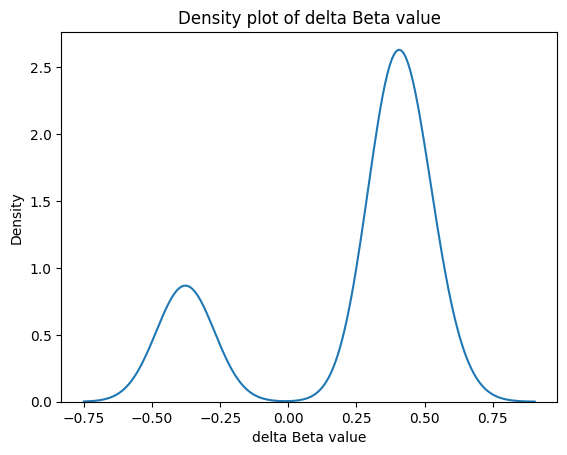

In [71]:
# DEBUG
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(TSS_threshold["dbeta"])
plt.xlabel("delta Beta value")
plt.title("Density plot of delta Beta value")
# END

In [ ]:
# train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [72]:
normal_count = (train_df.iloc[-1, 1:] == 0).sum()
df_gene = train_df.iloc[:-1, :]
df_gene = df_gene[df_gene[df_gene.columns[0]].isin(dbeta["ID"])]
X = df_gene.iloc[:, 1:].reset_index(drop=True).T
y = [0 if i < normal_count else 1 for i in range(X.shape[0])]
# DEBUG
print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")
# END

X shape: (802, 18652)
y shape: 802


In [38]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

df = pd.DataFrame(
    {
        "Principal Component 1": X_pca[:, 0],
        "Principal Component 2": X_pca[:, 1],
        "Principal Component 3": X_pca[:, 2],
        "Class": y,
    }
)
print(df.shape)
fig = px.scatter_3d(
    df,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    color="Class",
    title="PCA of Dataset",
    color_continuous_scale="Viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3",
    )
)

# fig.show()

fig.write_html(f"{trainOutPath}/preprocess_filtering_pca.html")
# open in browser

NameError: name 'X' is not defined

### Sec. 3 Machine Learning
1. remove hypo-methylated genes
2. RFE
3. RFECV (tbd)

In [9]:
config = load_config(CONFIG_PATH)
threshold = config["preprocess"]["filtering"]["threshold"]
TSS_threshold = pd.read_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv")

In [10]:
TSS_threshold_hyper = TSS_threshold[TSS_threshold["dbeta"] > 0]
# DEBUG
TSS_threshold_hyper
# END

,ID,gene,dbeta,feature
1,cg24613080,ACCN1,0.393994,TSS1500
2,cg02131967,ACE,0.380513,TSS1500
3,cg10266490,ACOT11,0.383674,TSS200
4,cg14672994,ACSF2,0.383849,TSS1500
5,cg25558103,ADAM11,0.351653,TSS1500
...,...,...,...,...
355,cg05470554,WNT16,0.352612,TSS200
356,cg06274159,ZFP42,0.420692,TSS200
357,cg16014085,ZNF48,0.377859,TSS1500
358,cg16731240,ZNF577,0.559272,TSS200


In [7]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")
test_df = pd.read_csv(f"{testOutPath}/all_beta_normalized_1.csv")

In [11]:
X_train = train_df[train_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]
X_test = test_df[test_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]

In [12]:
X_train = X_train.iloc[:, 1:].T.values.tolist()
X_test = X_test.iloc[:, 1:].T.values.tolist()

In [13]:
config = load_config(CONFIG_PATH)
normal_count_train = config["preprocess"]["merge_and_split"][
    "training_class_distribution"
][0]
normal_count_test = config["preprocess"]["merge_and_split"][
    "testing_class_distribution"
][0]
y_train = [0 if i < normal_count_train else 1 for i in range(len(X_train))]
y_test = [0 if i < normal_count_test else 1 for i in range(len(X_test))]

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    auc,
    roc_curve,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV

In [15]:
selection_models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel="linear", random_state=42),
}

param_xgb = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "min_child_weight": [40, 50, 60],
}

param_rf = {
    "n_estimators": [50, 100, 150, 200],
    "min_samples_split": [80, 90],
    "min_samples_leaf": [80, 90],
    "max_features": [5, 10, 20],
}

param_svm = {"kernel": ["rbf", "poly", "sigmoid"], "C": [50, 100, 200]}

param_dt = {
    "min_samples_split": [70, 80, 90],
    "min_samples_leaf": [70, 80, 90],
    "max_features": [5, 10, 20],
}

def set_parameters(model: object, param_grid: dict) -> object:
    grid_search = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2
    )
    return grid_search

xgb_model = set_parameters(XGBClassifier(random_state=42), param_xgb)
rf_model = set_parameters(RandomForestClassifier(random_state=42), param_rf)
svm_model = set_parameters(SVC(random_state=42), param_svm)
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

train_models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "SVM": svm_model,
}


In [16]:
def append_to_file(file_name: str, data: pd.DataFrame) -> None:
        if not os.path.isfile(file_name):
            data.to_csv(file_name, index=False)
        else:
            data.to_csv(file_name, index=False, mode="a", header=False)

def record(
    best_estimator: object,
    X: pd.DataFrame,
    y: pd.Series,
    selection_model_name: str,
    train_model_name: str,
    feature_count: int,
    best_score: float,
    best_params: dict,
    filepath: str,
) -> None:

    y_pred_on_X = best_estimator.predict(X)

    tn, fp, _, _ = confusion_matrix(y, y_pred_on_X).ravel()
    accuracy = accuracy_score(y, y_pred_on_X)
    recall = recall_score(y, y_pred_on_X)
    specificity = tn / (tn + fp)
    precision = precision_score(y, y_pred_on_X)

    fpr, tpr, _ = roc_curve(y, y_pred_on_X)
    roc_auc = auc(fpr, tpr)
    fpr = fpr.tolist()
    tpr = tpr.tolist()

    append_to_file(
        f"{filepath}/rfe.csv",
        pd.DataFrame(
            [
                {
                    "selection_model": selection_model_name,
                    "train_model": train_model_name,
                    "features": feature_count,
                    "accuracy": accuracy,
                    "recall": recall,
                    "speficity": specificity,
                    "precision": precision,
                    "f1_score": f1_score(y, y_pred_on_X),
                    "J-index": recall + specificity - 1,
                    "AUC": roc_auc,
                    "MCC": matthews_corrcoef(y, y_pred_on_X),
                    "Mean cross-validated score": best_score,
                    "Best parameters": best_params,
                }
            ]
        ),
    )
    append_to_file(
        f"{filepath}/fpr_tpr.csv",
        pd.DataFrame(
            [
                {
                    "selection_model": selection_model_name,
                    "train_model": train_model_name,
                    "features": feature_count,
                    "fpr": fpr,
                    "tpr": tpr,
                    "AUC": roc_auc,
                }
            ]
        ),
    )


In [17]:
for selection_model_name, selection_model in selection_models.items():
    for feature_count in range(25, 36, 5):
        rfe = RFE(estimator=selection_model, n_features_to_select=feature_count)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_test_rfe = rfe.transform(X_test)
        selected_feature_names = (
            pd.DataFrame(TSS_threshold_hyper.iloc[rfe.support_, 1])
            .reset_index(drop=True)
            .T
        )

        label = f"{selection_model_name}_{feature_count}"

        selected_feature_names.insert(0, "selection_model_name", label)

        append_to_file(
            f"{trainOutPath}/selected_feature_names.csv", selected_feature_names
        )

        for train_model_name, train_model in train_models.items():
            train_model.fit(X_train_rfe, y_train)
            best_params = train_model.best_params_

            best_score = train_model.best_score_

            record(
                train_model.best_estimator_,
                X_train_rfe,
                y_train,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{trainOutPath}",
            )
            record(
                train_model.best_estimator_,
                X_test_rfe,
                y_test,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{testOutPath}",
            )

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


D:\Users\005535\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


D:\Users\005535\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 

In [18]:
fpr_tpr_tr = pd.read_csv(f"{trainOutPath}/fpr_tpr.csv")
fpr_tpr_te = pd.read_csv(f"{testOutPath}/fpr_tpr.csv")

In [19]:
rfe_tr = pd.read_csv(f"{trainOutPath}/rfe.csv")
rfe_te = pd.read_csv(f"{testOutPath}/rfe.csv")

In [30]:
rfe_j = pd.merge(rfe_tr, rfe_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
fpr_tpr_j = pd.merge(fpr_tpr_tr, fpr_tpr_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
J = pd.merge(rfe_j, fpr_tpr_j, on=["selection_model", "train_model", "features", "AUC_train", "AUC_test"])

In [31]:
import ast

J["fpr_train"] = J["fpr_train"].apply(ast.literal_eval)
J["tpr_train"] = J["tpr_train"].apply(ast.literal_eval)
J["fpr_test"] = J["fpr_test"].apply(ast.literal_eval)
J["tpr_test"] = J["tpr_test"].apply(ast.literal_eval)

In [40]:
import plotly.graph_objects as go

fig = go.Figure()

for index, row in J.iterrows():
    if row['AUC_train'] > 0.5:
        fig.add_trace(go.Scatter(
            x=row['fpr_train'],
            y=row['tpr_train'],
            mode='lines',
            name=f"{row['selection_model']} {row['train_model']} (AUC = {row['AUC_train']:.3f})"
        ))

# Add the random guess line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='grey'),
    name='Random Guess'
))

# Update layout
fig.update_layout(
    title='ROC Curves for Different Models',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',
    legend_title='Model',
    template='plotly_white',
    width=1600,  # Set the width of the canvas
    height=1200   # Set the height of the canvas
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'XGBoost XGBoost (AUC = 0.935)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9625935162094763, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Random Forest (AUC = 0.934)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9600997506234414, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Decision Tree (AUC = 0.933)',
              'type': 'scatter',
              'x': [0.0, 0.09476309226932668, 1.0],
              'y': [0.0, 0.9600997506234414, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost SVM (AUC = 0.999)',
              'type': 'scatter',
              'x': [0.0, 0.0, 1.0],
              'y': [0.0, 0.9975062344139651, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost XGBoost (AUC = 0.934)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9600997506234414, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Random Forest (AUC = 0.933)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9576059850374065, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Decision Tree (AUC = 0.931)',
              'type': 'scatter',
              'x': [0.0, 0.0773067331670823, 1.0],
              'y': [0.0, 0.940149625935162, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost SVM (AUC = 0.999)',
              'type': 'scatter',
              'x': [0.0, 0.0, 1.0],
              'y': [0.0, 0.9975062344139651, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost XGBoost (AUC = 0.935)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9625935162094763, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Random Forest (AUC = 0.933)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9576059850374065, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost Decision Tree (AUC = 0.930)',
              'type': 'scatter',
              'x': [0.0, 0.10723192019950124, 1.0],
              'y': [0.0, 0.9675810473815462, 1.0]},
             {'mode': 'lines',
              'name': 'XGBoost SVM (AUC = 0.999)',
              'type': 'scatter',
              'x': [0.0, 0.0, 1.0],
              'y': [0.0, 0.9975062344139651, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest XGBoost (AUC = 0.935)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9625935162094763, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest Random Forest (AUC = 0.933)',
              'type': 'scatter',
              'x': [0.0, 0.09226932668329177, 1.0],
              'y': [0.0, 0.9576059850374065, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest Decision Tree (AUC = 0.930)',
              'type': 'scatter',
              'x': [0.0, 0.10723192019950124, 1.0],
              'y': [0.0, 0.9675810473815462, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest SVM (AUC = 0.998)',
              'type': 'scatter',
              'x': [0.0, 0.0, 1.0],
              'y': [0.0, 0.9950124688279302, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest XGBoost (AUC = 0.943)',
              'type': 'scatter',
              'x': [0.0, 0.07481296758104738, 1.0],
              'y': [0.0, 0.9600997506234414, 1.0]},
             {'mode': 'lines',
              'name': 'Random Forest Random Forest (AUC = 0.933)',
              'type': 'scatter',
              'x': [0.0, 0.08977556109725686, 1.0],
              'y': [0

In [58]:
import plotly.graph_objects as go

# Count the occurrences for AUC_train > 0.5
auc_train_greater_than_0_5 = J[J['AUC_train'] > 0.5]
auc_test_greater_than_0_5_for_train_greater_than_0_5 = (auc_train_greater_than_0_5['AUC_test'] > 0.5).sum()
auc_test_equal_to_0_5_for_train_greater_than_0_5 = (auc_train_greater_than_0_5['AUC_test'] == 0.5).sum()

# Count the occurrences for AUC_train = 0.5
auc_train_equal_to_0_5 = J[J['AUC_train'] == 0.5]
auc_test_greater_than_0_5_for_train_equal_to_0_5 = (auc_train_equal_to_0_5['AUC_test'] > 0.5).sum()
auc_test_equal_to_0_5_for_train_equal_to_0_5 = (auc_train_equal_to_0_5['AUC_test'] == 0.5).sum()

# Create a bar chart
labels = [
    'AUC_train > 0.5 & AUC_test > 0.5',
    'AUC_train > 0.5 & AUC_test = 0.5',
    'AUC_train = 0.5 & AUC_test > 0.5',
    'AUC_train = 0.5 & AUC_test = 0.5'
]
counts = [
    auc_test_greater_than_0_5_for_train_greater_than_0_5,
    auc_test_equal_to_0_5_for_train_greater_than_0_5,
    auc_test_greater_than_0_5_for_train_equal_to_0_5,
    auc_test_equal_to_0_5_for_train_equal_to_0_5
]

fig = go.Figure(data=[go.Bar(x=labels, y=counts, marker_color=['blue', 'orange', 'green', 'red'])])
fig.update_layout(
    title='Count of AUC_train and AUC_test Values',
    xaxis_title='AUC Value Combination',
    yaxis_title='Count'
)
fig.show()